In [1]:
import numpy as np 
import pandas as pd 

In [2]:
!pip install ultralytics transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 15.5 MB/s eta 0:00:00


In [3]:
import wandb
import random
import cv2 as cv
from ultralytics import YOLO
from matplotlib import pyplot as plt
from IPython.display import Image, display
from transformers import pipeline
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Set your data directory path
DATA_DIR = '/kaggle/input/drone-garbage-detection/datasets'

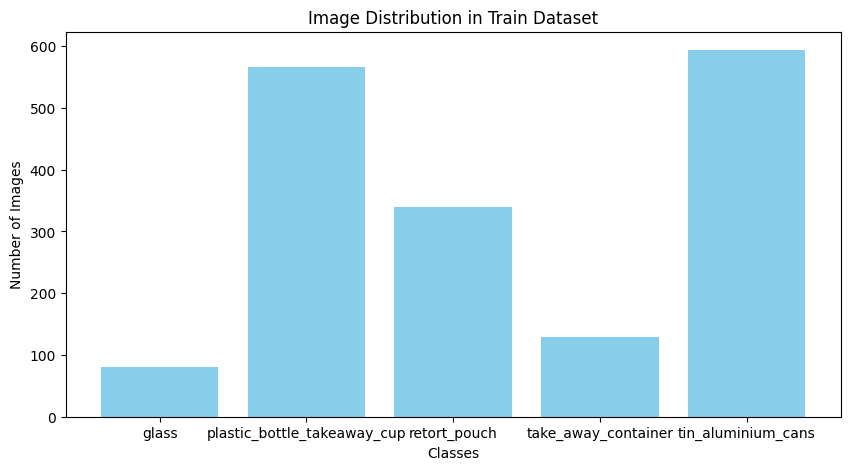

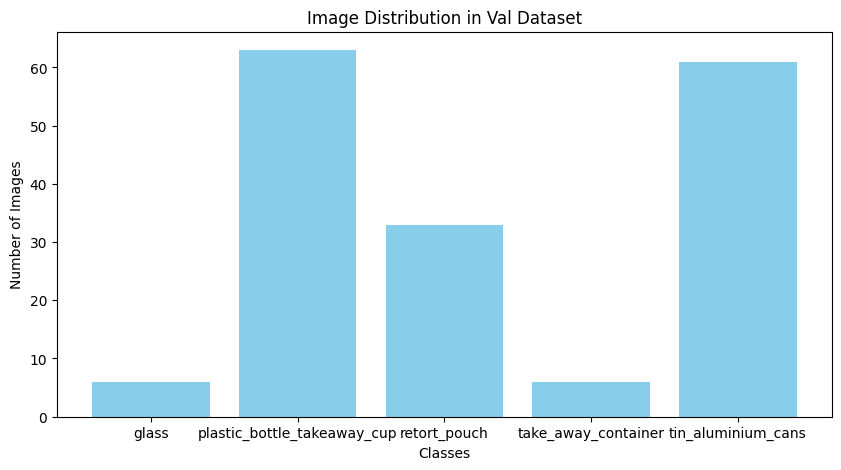

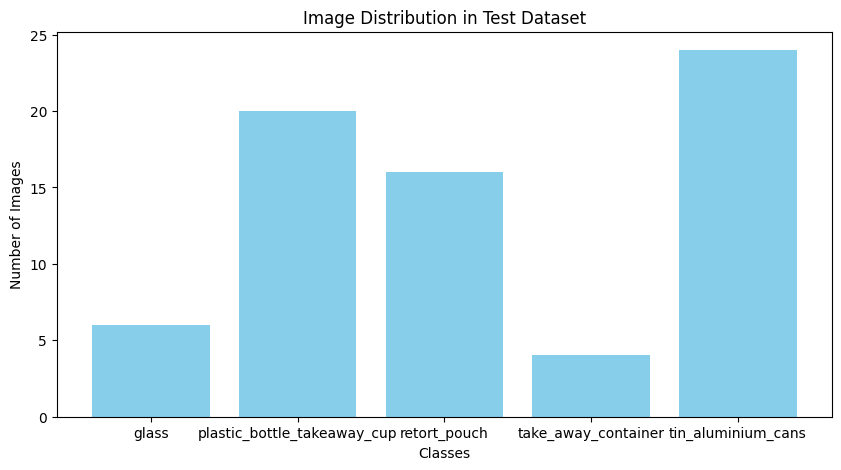

In [6]:
def eda(data_dir):
    dataset_types = ['train', 'val', 'test']
    classes = ['glass', 'plastic_bottle_takeaway_cup', 'retort_pouch', 'take_away_container', 'tin_aluminium_cans']

    # Initialize a dictionary to store counts
    data_counts = {dataset_type: {cls: 0 for cls in classes} for dataset_type in dataset_types}

    for dataset_type in dataset_types:
        for cls in classes:
            cls_path = os.path.join(data_dir, dataset_type, cls)
            if os.path.exists(cls_path):
                data_counts[dataset_type][cls] = len(os.listdir(cls_path))
    
    # Plotting the distribution
    for dataset_type in dataset_types:
        plt.figure(figsize=(10, 5))
        plt.bar(data_counts[dataset_type].keys(), data_counts[dataset_type].values(), color='skyblue')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.title(f'Image Distribution in {dataset_type.capitalize()} Dataset')
        plt.show()

# Run the EDA function
eda(DATA_DIR)

In [7]:
!yolo task=classify mode=train model=yolov8l-cls.pt data='{DATA_DIR}' epochs=10 imgsz=128


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


100%|███████████████████████████████████████| 71.7M/71.7M [00:00<00:00, 316MB/s]
Ultralytics YOLOv8.2.101 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=/kaggle/input/drone-garbage-detection/datasets, epochs=10, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

In [8]:
!yolo task=classify mode=val model=/kaggle/working/runs/classify/train/weights/best.pt data='{DATA_DIR}'

Ultralytics YOLOv8.2.101 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8l-cls summary (fused): 133 layers, 36,190,981 parameters, 0 gradients, 98.7 GFLOPs
train: /kaggle/input/drone-garbage-detection/datasets/train... found 1710 images in 5 classes ✅ 
val: /kaggle/input/drone-garbage-detection/datasets/val... found 169 images in 5 classes ✅ 
test: /kaggle/input/drone-garbage-detection/datasets/test... found 70 images in 5 classes ✅ 
val: Scanning /kaggle/input/drone-garbage-detection/datasets/val... 169 images, 
val: WARNING ⚠️ Cache directory /kaggle/input/drone-garbage-detection/datasets is not writeable, cache not saved.
               classes   top1_acc   top5_acc: 100%|██████████| 11/11 [00:00<00:0
                   all      0.994          1
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val
💡 Learn more at https://docs.ultralytics.com/modes/val


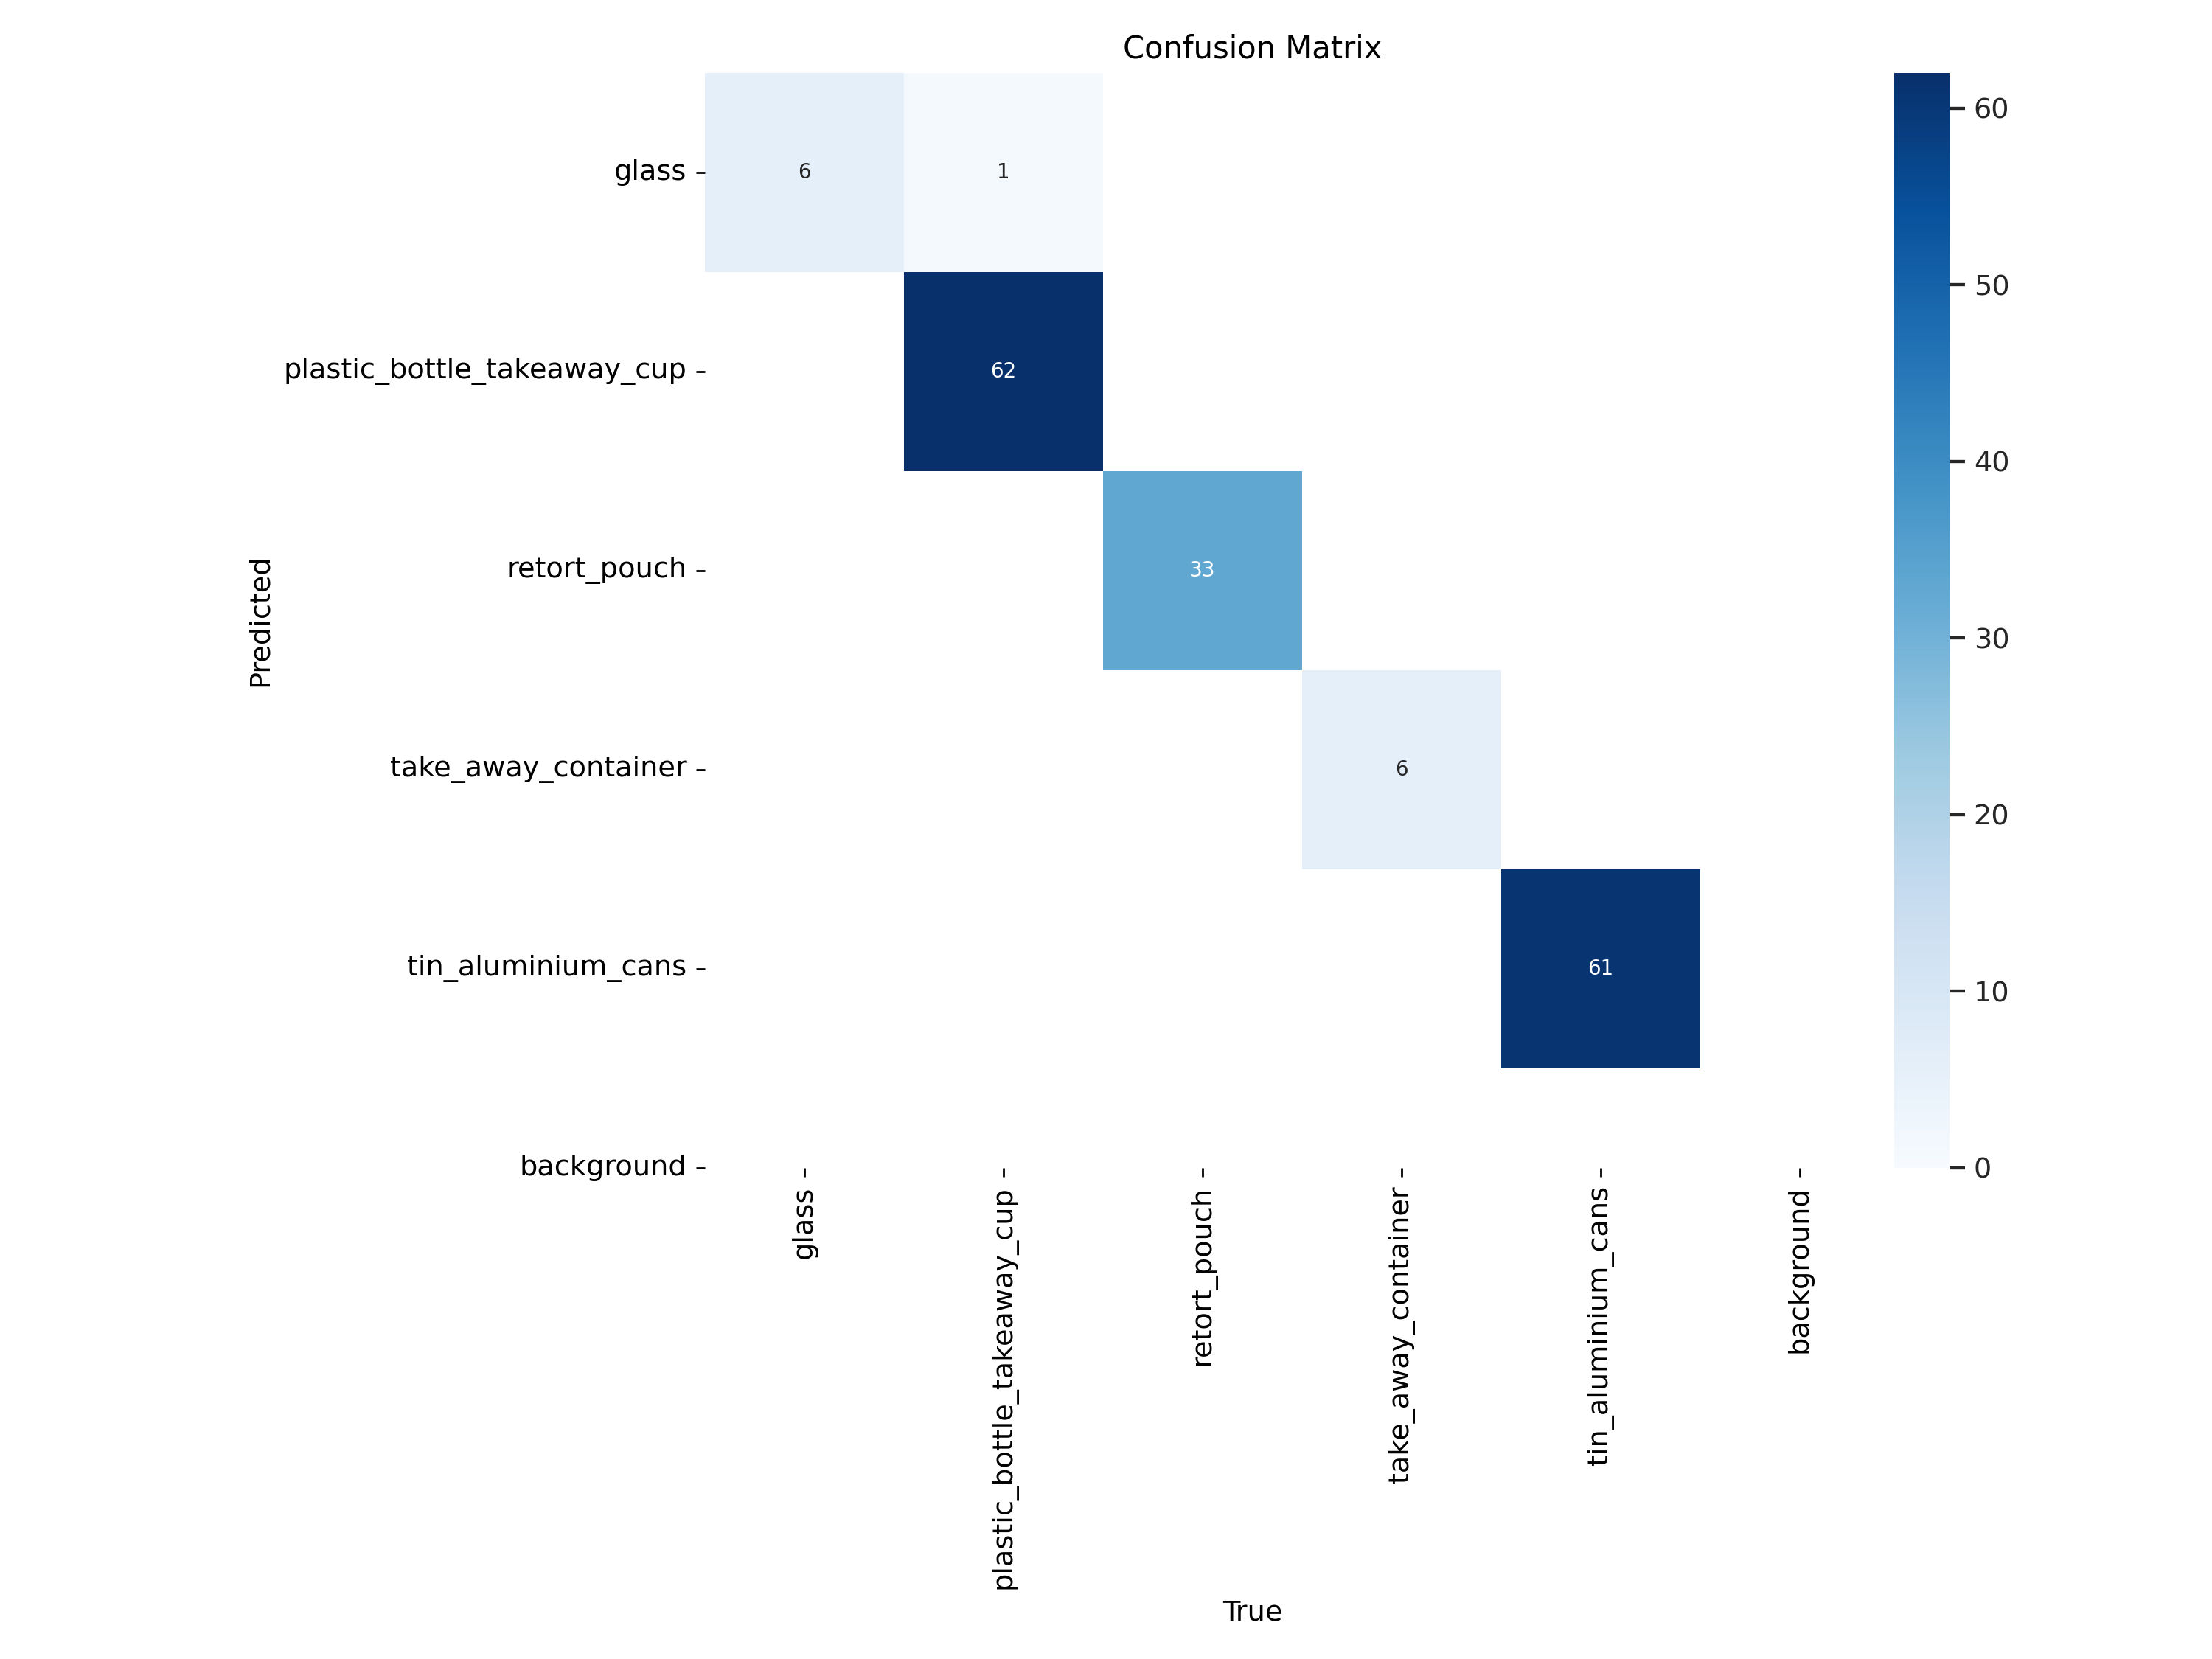

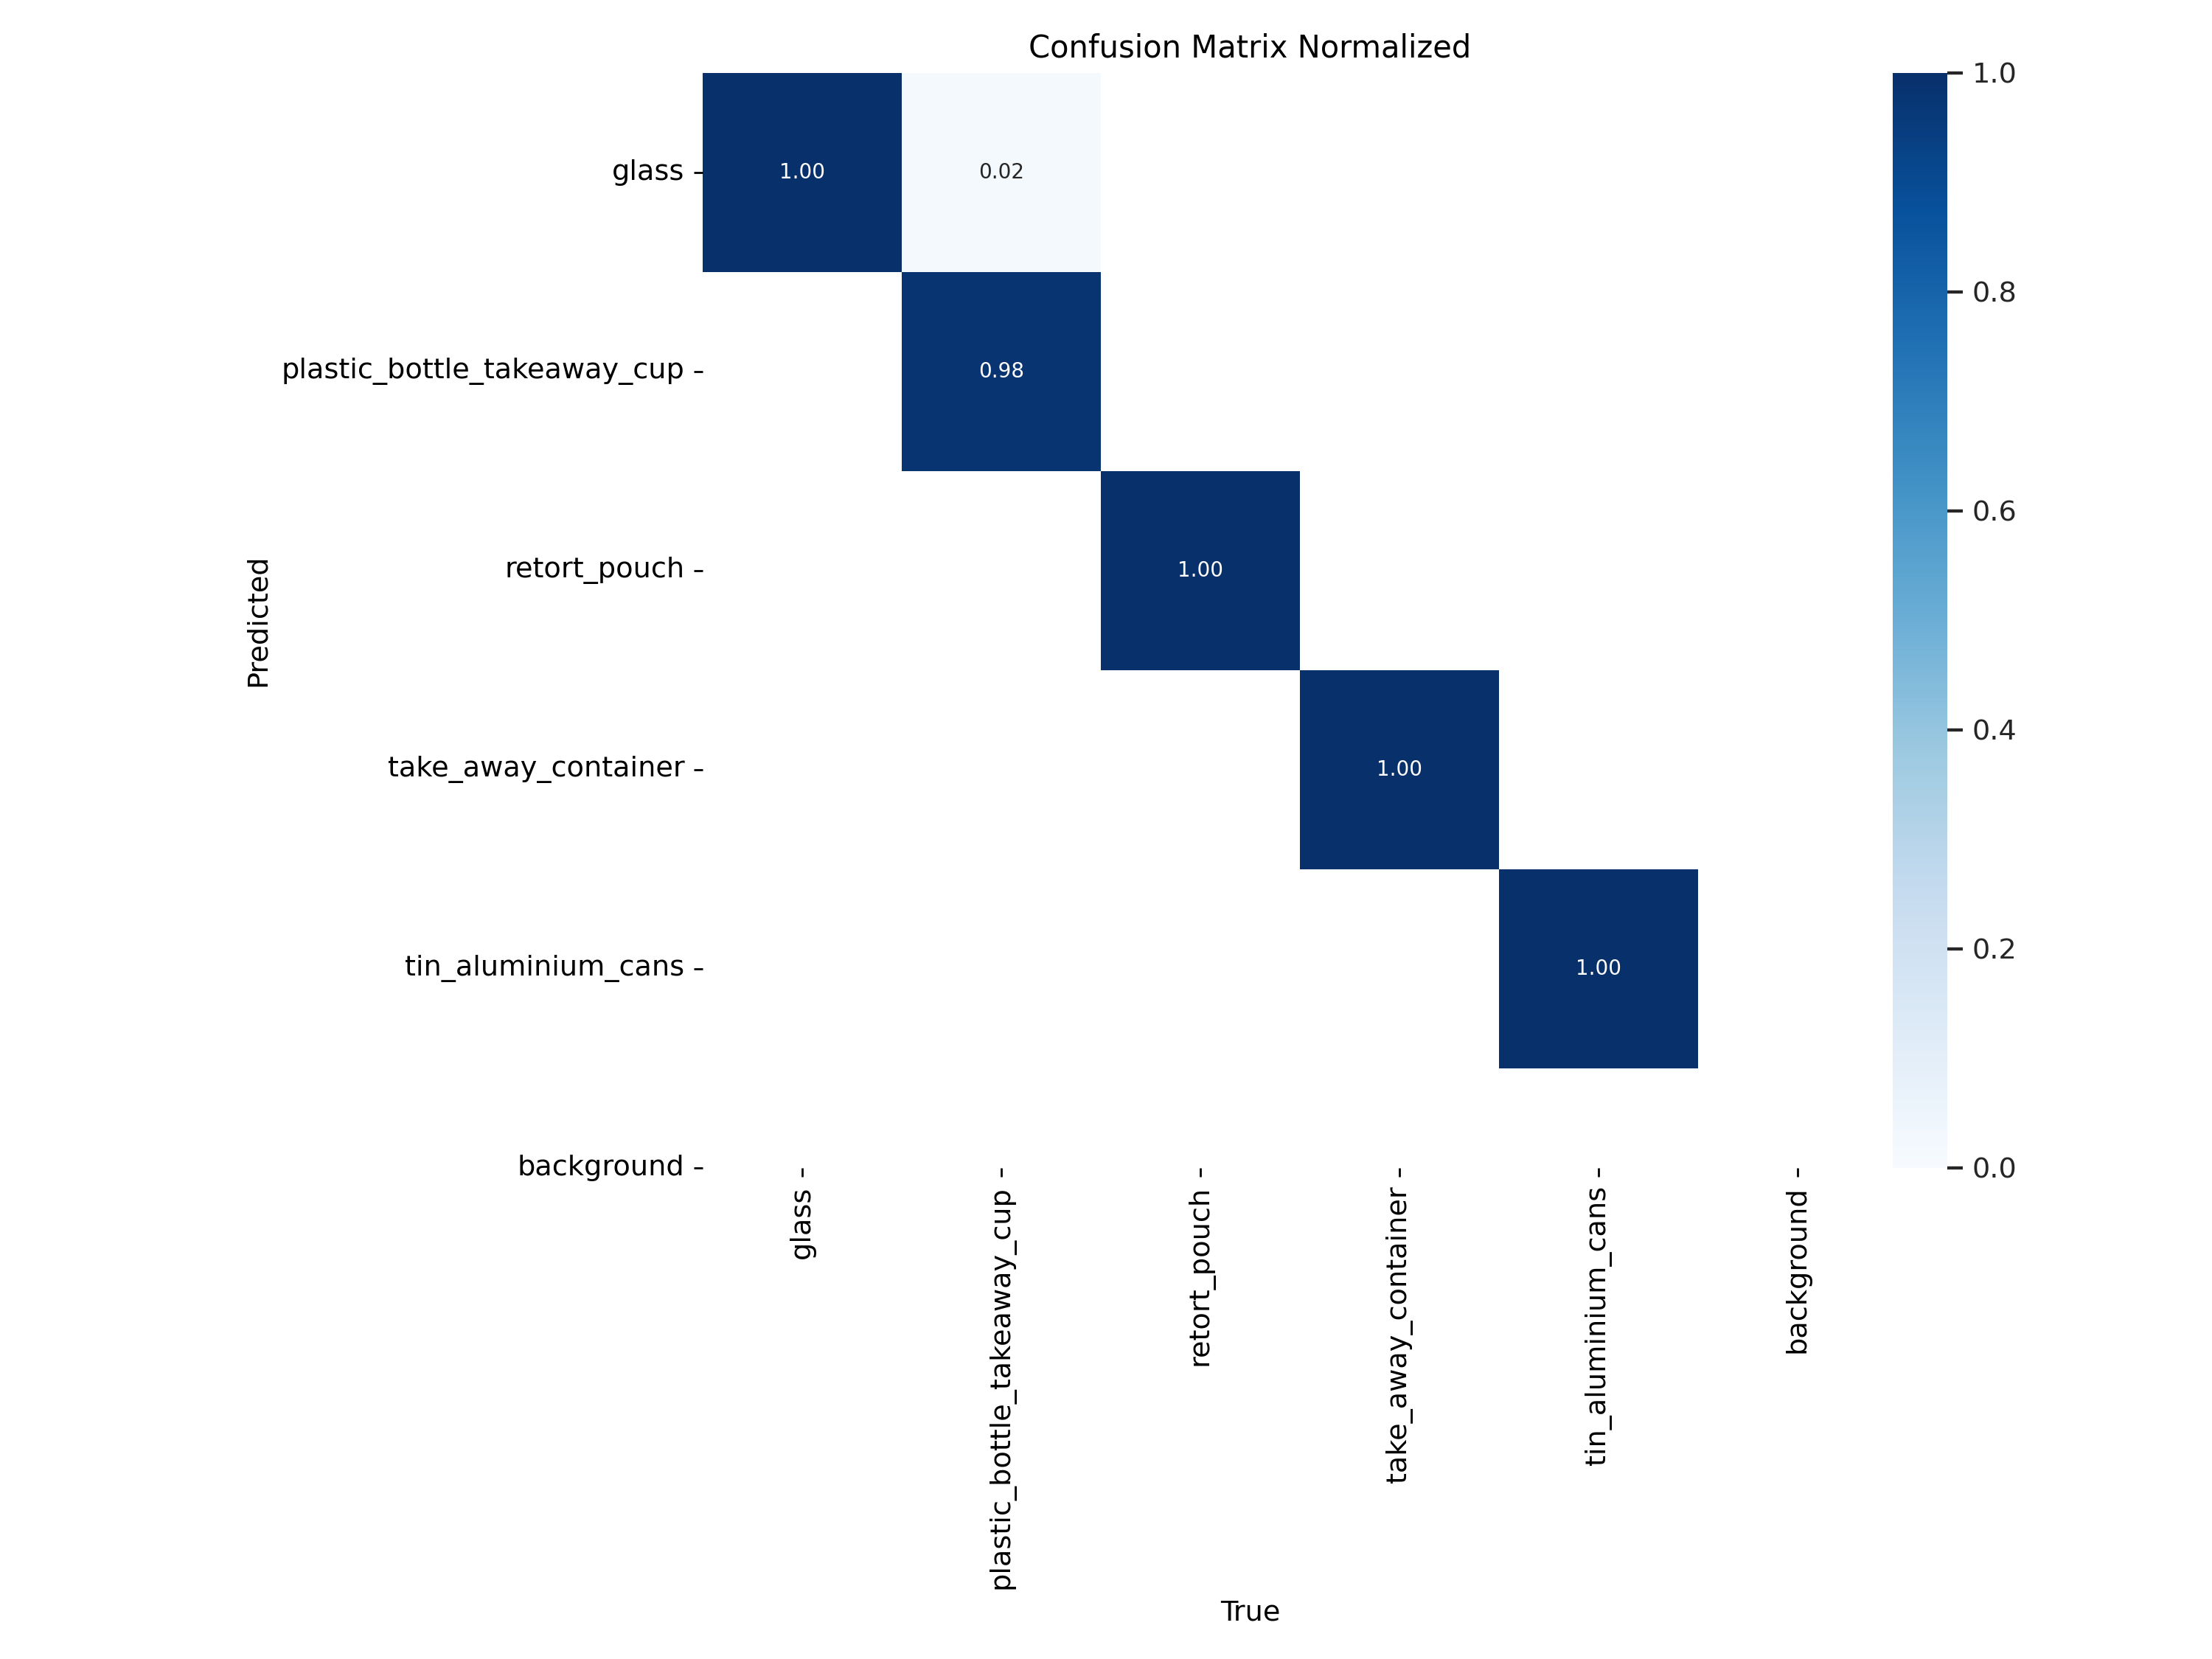

In [9]:
# Display confusion matrix
display(Image(filename='/kaggle/working/runs/classify/val/confusion_matrix.png'))
display(Image(filename='/kaggle/working/runs/classify/val/confusion_matrix_normalized.png'))

In [10]:
predict = !yolo task=classify mode=predict model=/kaggle/working/runs/classify/train/weights/best.pt conf=0.25 source="{DATA_DIR}/test/glass/VID_20230723_101947_0036_MP4-5_jpg.rf.5363d38db2e132230b11ebc271d2004b.jpg"

import re
for line in predict:
    match = re.search(r'(\w+)\s1\.00', line)
    if match:
        class_name = match.group(1)
        print("Class with confidence 1.00:", class_name)
        break

Class with confidence 1.00: glass


In [11]:
import os
import csv
import re

# Function to predict classes for all test images and save results in CSV
def predict_test_images(model_path, data_dir, output_csv):
    # Initialize CSV writer
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Image', 'Predicted Class'])

        # Iterate through test images
        test_dir = os.path.join(data_dir, 'test')
        for cls in os.listdir(test_dir):
            cls_dir = os.path.join(test_dir, cls)
            if os.path.isdir(cls_dir):
                for img_file in os.listdir(cls_dir):
                    img_path = os.path.join(cls_dir, img_file)
                    # Predict class for each test image
                    predict = !yolo task=classify mode=predict model={model_path} source="{img_path}"
                    # Extract predicted class from output
                    for line in predict:
                        match = re.search(r'(\w+)\s1\.00', line)
                        if match:
                            predicted_class = match.group(1)
                            writer.writerow([img_file, predicted_class])
                            break

# Set paths
MODEL_PATH = '/kaggle/working/runs/classify/train/weights/best.pt'
DATA_DIR = '/kaggle/input/drone-garbage-detection/datasets'
OUTPUT_CSV = '/kaggle/working/test_predictions.csv'

# Predict classes for all test images and save results in CSV
predict_test_images(MODEL_PATH, DATA_DIR, OUTPUT_CSV)